In [65]:
import pandas as pd
import numpy as np
import random
import os
import time

start_time = time.time()

path = os.path.abspath('.')

simRAO = 1000

nMTCD = 10000

nMTCD_success = 0  # total number of device that transmit success

nMTCD_fail = 0  # total number of device that transmit failed

Backoff = 2  # Backoff Indicator = 20ms

maxTrans = 10  # Maximum number of preamble transmission

N_PRB = 25  # Number of Sidelink Physical Resource Block

N_PRB_arrange = 20  # the number of arranged PRB

N_preamble = 54  # Number of PRACH Preamble

file_path = path + f'/MTCD_data_{nMTCD}.csv'
MTCD_data = pd.read_csv(file_path, index_col=False)

"""
RA_data
    records RA parameter and simulation result of every device
    the parameters required in enB <-> device communication
    Index:
        device_id
    Columns 3:
        RA_init:     Integer,
                     next frame the device send RA request
        RA_first:    Integer,
                     first frame the device send RA request
        RA_success:  Integer,
                     frame the device complete RA procedure
        RA_transmit: Integer,
                     number of the device trying to send RA request
"""
RA_data = MTCD_data[['RA_init', 'RA_success', 'RA_transmit', 'RA_first']]

"""
D2D_member
    records D2D parameter of every Member
    also records numerical result for every Member
    the parametes required in Member -> Header communication
    Index:
        device_id
    Columns 7:
        Header:   Integer,
                  the Header of belonging D2D group
                  also indicate the group Header's device_id
        Member:   Boolen,
                  whether the device is a Member
        arrange:  Integer,
                  indicate the beloneing arrange sequence
        request:  Boolen,
                  whether the Member will send D2D request
        response: Boolean,
                  whether the device received its Header Response
        success:  Integer,
                  the frame the device finish D2D transmission (-1: not success yet)
        transmit: Integer,
                  number of the Member trying to send D2D request
"""
D2D_member = pd.DataFrame(
    columns=['Header', 'Member', 'arrange',
             'request', 'response', 'success', 'transmit'],
)

# assign group
D2D_member['Header'] = MTCD_data['clusters']

# assign type
D2D_member['Member'] = (D2D_member.index != D2D_member['Header'])

# assign arrange
for header in D2D_member['Header'].unique():
    members = D2D_member.loc[(D2D_member['Header'] == header) &
                             (D2D_member['Member'])]
    n = 0
    for device_id in members.index:
        D2D_member.at[device_id, 'arrange'] = n // N_PRB_arrange
        n += 1

# initialize request
D2D_member['request'] = np.zeros(nMTCD, dtype=bool)

# initialize response
D2D_member['response'] = np.zeros(nMTCD, dtype=bool)

# initialize success = -1
D2D_member['success'] = np.full(nMTCD, -1)

# initialize transmit
D2D_member['transmit'] = np.zeros(nMTCD, dtype=int)

"""
D2D_group
    records D2D parameter of every Header
    also records numerical result for every Header
    records the parameter required by Header -> Member communication
    Index:
        default sequence
    Columns 6:
        Header:     Integer,
                    device_id of the group Header
        class:      Integer,
                    the barring class of the beloneing D2D group
        N_member:   Integer,
                    the total number of device (member+header) in the group
        arr_seq:    Integer,
                    current arrange sequence
        N_RA:       Integer,
                    number of RA_request within the group
        HL:         Bollean,
                    Whether the group is in HL or not
"""
D2D_group = pd.DataFrame(
    columns=['Header', 'class', 'N_member', 'arr_seq', 'N_RA', 'HL']
)

# initialize Header
D2D_group['Header'] = MTCD_data['clusters'].unique()

# assign Class
N_group = len(D2D_group)
N_Class = (N_group // N_preamble) + 1
seq = 0
for group in range(N_group):
    D2D_group.at[group, 'class'] = group // N_preamble

# initialize N_member
D2D_group['N_member'] = D2D_member.groupby(['Header']).size().values

# initialize current arrange sequence
D2D_group['arr_seq'] = np.zeros(N_group, dtype=int)

# initialize N_RA
D2D_group['N_RA'] = np.zeros(N_group, dtype=int)

# initialize N_RA
D2D_group['HL'] = np.zeros(N_group, dtype=bool)

"""
BS_schedule
    indicate the broadcast information for SIB2
    update every 16 system frame
    Do not require initialize
    Index:
        system_frame
    Columns 2:
        class: List[Integer],
               the class can initiate RA procedure
        TDCR:  Char,
               indicate the type of TDCR level
               N:  normal loading, not a TDCR frame
               M:  medium loading congestion resolving
                   1 frame per period
                   2 RA_request per group
               H:  heavy loading congestion resolving
                   2 frame per period
                   1 RA_request per group
"""
BS_schedule = pd.DataFrame(
    columns=['class', 'TDCR'],
)

"""
D2D_result
    records the numerical result of D2D sidelink
    Index:
        sequence of SC-Period
    Columns 4:
         frame:      Integer,
                     the system frame when the SC-period-1 ends
         N_request:  Integer,
                     number of device send D2D_request to its header
         N_response: Integer,
                     number of D2D device that receive its Header response
         N_HL:       Integer,
                     number of Heavy Loading D2D_group
"""
D2D_result = pd.DataFrame(
    columns=['frame', 'N_request', 'N_response', 'N_HL'],
)

#  records the current loading status of each classes
Class_Status = ['N'] * N_Class

D2D_period = 8  # 40 ms Member -> Header, 40ms Header -> Member

SIB2_period = 16  # broadcast period of SIB2: 160ms

N_Normal_frame_total = 0

In [32]:
simRAO = 2000
nMTCD = 30000
MTCD_data = pd.read_csv(f'MTCD_data_{nMTCD}.csv', index_col=False)

In [33]:
data = np.zeros((simRAO, 4), dtype=int)
Preamble_status = pd.DataFrame(
    data,
    columns=['nRA', 'empty', 'collided', 'success'],
)
Preamble_status.index.name = 'system frame'

In [34]:
print(Preamble_status.shape)
Preamble_status.sample(5)

(2000, 4)


,nRA,empty,collided,success
system frame,,,,
287,0,0,0,0
648,0,0,0,0
1529,0,0,0,0
1457,0,0,0,0
1969,0,0,0,0


In [29]:
RA_data = MTCD_data[['RA_init', 'RA_first', 'RA_success', 'RA_transmit']]
RA_data.index.name = 'device_id'

In [30]:
print(RA_data.shape)
RA_data.sample(5)

(30000, 4)


,RA_init,RA_first,RA_success,RA_transmit
device_id,,,,
7505,416,416,-1,0
14971,300,300,-1,0
24892,506,506,-1,0
19989,213,213,-1,0
4439,385,385,-1,0


In [31]:
D2D_member = pd.DataFrame(
    columns=['group', 'Member', 'arrange', 'request', 'delay', 'transmit'],
)

# assign group
D2D_member['group'] = MTCD_data['clusters']

# assign type
D2D_member['Member'] = (D2D_member.index != D2D_member['group'])

# assign arrange
arrangePRB = 20
for group in D2D_member['group'].unique():
    members = D2D_member.loc[(D2D_member['group'] == group) &
                             (D2D_member['Member'])]
    n = 0
    for device_id, member in members.iterrows():
        D2D_member.at[device_id, 'arrange'] = n // arrangePRB
        n += 1

# initiate request
D2D_member['request'] = np.zeros(nMTCD, dtype=bool)

# initiate delay
D2D_member['delay'] = np.zeros(nMTCD, dtype=int)

# initiate transmit
D2D_member['transmit'] = np.zeros(nMTCD, dtype=int)

In [32]:
print(D2D_member.shape)
D2D_member.loc[D2D_member['Member'] == False].sample(5)

(30000, 6)


,group,Member,arrange,request,delay,transmit
device_id,,,,,,
316,316,False,NaN,False,0,0
127,127,False,NaN,False,0,0
145,145,False,NaN,False,0,0
84,84,False,NaN,False,0,0
93,93,False,NaN,False,0,0


In [33]:
D2D_group = pd.DataFrame(
    columns=['Header', 'class', 'seq_class', 'N_member', 'RA_request', 'arrange', 'HL']
)
D2D_group['Header'] = MTCD_data['clusters'].unique()

In [34]:
N_preamble = 54
N_group = len(D2D_group)
N_class = (N_group // N_preamble) + 1
seq = 0
ind = 0
print(N_group, N_class)

219 5


In [35]:
for group in range(N_group):
    D2D_group.at[group, 'class'] = group // N_preamble
    # assign inter-class sequence
    D2D_group.at[group, 'seq_class'] = seq
    seq = (seq+1) % N_preamble
D2D_group

,Header,class,seq_class,N_member,RA_request,arrange,HL
0,0,0,0,NaN,NaN,NaN,NaN
1,1,0,1,NaN,NaN,NaN,NaN
2,2,0,2,NaN,NaN,NaN,NaN
3,3,0,3,NaN,NaN,NaN,NaN
4,4,0,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
214,1004,3,52,NaN,NaN,NaN,NaN
215,1056,3,53,NaN,NaN,NaN,NaN
216,1756,4,0,NaN,NaN,NaN,NaN
217,9805,4,1,NaN,NaN,NaN,NaN


In [36]:
D2D_group['N_member'] = D2D_member.groupby(['group']).size().values
D2D_group

,Header,class,seq_class,N_member,RA_request,arrange,HL
0,0,0,0,159,NaN,NaN,NaN
1,1,0,1,159,NaN,NaN,NaN
2,2,0,2,162,NaN,NaN,NaN
3,3,0,3,120,NaN,NaN,NaN
4,4,0,4,138,NaN,NaN,NaN
...,...,...,...,...,...,...,...
214,1004,3,52,96,NaN,NaN,NaN
215,1056,3,53,106,NaN,NaN,NaN
216,1756,4,0,119,NaN,NaN,NaN
217,9805,4,1,55,NaN,NaN,NaN


In [37]:
for i, header in enumerate(D2D_group['Header']):
    D2D_group.at[i, 'N_member'] = len(D2D_member)

In [38]:
BS_schedule = pd.DataFrame(
    columns=['class', 'TDCR'],
)

# assign class of every frame
BS_schedule['class'] = [f % N_class for f in range(simRAO)]

# initialize TDCR
BS_schedule['TDCR'] = np.zeros(simRAO, dtype=int)

In [39]:
BS_schedule

,class,TDCR
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1995,0,0
1996,1,0
1997,2,0
1998,3,0


In [40]:
schedule = BS_schedule.loc[np.arange(0,16)]
schedule

,class,TDCR
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,0,0
6,1,0
7,2,0
8,3,0
9,4,0


In [41]:
s = schedule.loc[(schedule['class'] == 1)]
s

,class,TDCR
1,1,0
6,1,0
11,1,0


In [42]:
s.iat[0, 1] = 1
s

,class,TDCR
1,1,1
6,1,0
11,1,0


In [43]:
s.index[0]

1

In [44]:
BS_schedule.at[s.index[0], 'TDCR'] = 1235
BS_schedule

,class,TDCR
0,0,0
1,1,1235
2,2,0
3,3,0
4,4,0
...,...,...
1995,0,0
1996,1,0
1997,2,0
1998,3,0


In [48]:
devices = RA_data.loc[(RA_data['RA_init'] == 125) & (RA_data['RA_transmit'] <= 10)]
devices['RA_transmit'] += 1

In [49]:
devices

,RA_init,RA_first,RA_success,RA_transmit
device_id,,,,
139,125,125,-1,1
2183,125,125,-1,1
3230,125,125,-1,1
4765,125,125,-1,1
15464,125,125,-1,1
16923,125,125,-1,1
18483,125,125,-1,1
21849,125,125,-1,1
21861,125,125,-1,1


In [53]:
RA_data.iloc[139]

RA_init        125
RA_first       125
RA_success      -1
RA_transmit      0
Name: 139, dtype: int64

In [55]:
D2D_member['response'] = np.full(nMTCD, -1)

In [56]:
D2D_member

,group,Member,arrange,request,delay,transmit,response
device_id,,,,,,,
0,0,False,NaN,False,0,0,-1
1,1,False,NaN,False,0,0,-1
2,2,False,NaN,False,0,0,-1
3,3,False,NaN,False,0,0,-1
4,4,False,NaN,False,0,0,-1
...,...,...,...,...,...,...,...
29995,112,True,8,False,0,0,-1
29996,1305,True,6,False,0,0,-1
29997,138,True,8,False,0,0,-1


In [71]:
D2D_group['HL'] = np.random.choice(a=[False, True], size=len(D2D_group))
D2D_group

,Header,class,seq_class,N_member,RA_request,arrange,HL
0,0,0,0,30000,NaN,NaN,False
1,1,0,1,30000,NaN,NaN,False
2,2,0,2,30000,NaN,NaN,True
3,3,0,3,30000,NaN,NaN,False
4,4,0,4,30000,NaN,NaN,False
...,...,...,...,...,...,...,...
214,1004,3,52,30000,NaN,NaN,False
215,1056,3,53,30000,NaN,NaN,False
216,1756,4,0,30000,NaN,NaN,True
217,9805,4,1,30000,NaN,NaN,True


In [92]:
class_groups = D2D_group.loc[D2D_group['class'] == 3]
HL_groups = class_groups.loc[class_groups['HL'] == False]
print(len(class_groups), len(HL_groups))

54 25


In [95]:
class_groups

,Header,class,seq_class,N_member,RA_request,arrange,HL
162,295,3,0,30000,NaN,NaN,False
163,312,3,1,30000,NaN,NaN,False
164,313,3,2,30000,NaN,NaN,True
165,317,3,3,30000,NaN,NaN,True
166,14070,3,4,30000,NaN,NaN,False
167,323,3,5,30000,NaN,NaN,False
168,431,3,6,30000,NaN,NaN,True
169,553,3,7,30000,NaN,NaN,False
170,327,3,8,30000,NaN,NaN,False
171,832,3,9,30000,NaN,NaN,True


In [97]:
class_groups['Header']

162      295
163      312
164      313
165      317
166    14070
167      323
168      431
169      553
170      327
171      832
172     2455
173      383
174      349
175      600
176      353
177      356
178      996
179     4350
180      375
181      376
182      870
183      736
184      422
185     1602
186     1088
187     2476
188     5902
189      454
190     4819
191      462
192     5862
193      472
194     2863
195      487
196     2662
197     4585
198     1524
199    11624
200      540
201     4577
202     1476
203     7742
204     7811
205      579
206     1305
207     2798
208      637
209      741
210      783
211     8188
212    10106
213      963
214     1004
215     1056
Name: Header, dtype: int64

In [99]:
N_PRB_arrange = 20

In [109]:
# test dummy data
D2D_member['request'] = np.random.choice(a=[False, True], size=len(D2D_member))
D2D_member['response'] = np.random.choice(a=[False, True], size=len(D2D_member))
D2D_member['transmit'] = np.random.uniform(low=0,high=20,size=nMTCD).astype(int)
D2D_member.sample(10)

,Header,Member,arrange,request,response,success,transmit
device_id,,,,,,,
13252,3260,True,2,True,False,-1,0
17900,2455,True,3,False,True,-1,1
29612,143,True,9,True,True,-1,1
18450,162,True,4,False,True,-1,7
14779,431,True,3,True,True,-1,9
8584,162,True,2,True,False,-1,9
13277,64,True,1,False,True,-1,10
20715,46,True,5,False,False,-1,5
25454,268,True,5,False,True,-1,17


In [110]:
valid_group_members = D2D_member.loc[(D2D_member['Header'] == 0) & (D2D_member['response'])]
valid_group_members

,Header,Member,arrange,request,response,success,transmit
device_id,,,,,,,
0,0,False,NaN,False,True,-1,11
100,0,True,0,True,True,-1,10
186,0,True,0,True,True,-1,0
212,0,True,0,True,True,-1,9
307,0,True,0,False,True,-1,3
...,...,...,...,...,...,...,...
26797,0,True,6,True,True,-1,5
27115,0,True,7,False,True,-1,1
27863,0,True,7,False,True,-1,6


4109

In [123]:
device_id = valid_group_members['transmit'].idxmax()
valid_group_members = valid_group_members.drop(device_id)

In [124]:
device_id = valid_group_members['transmit'].idxmax()
valid_group_members.loc[device_id]


Header          0
Member       True
arrange         1
request     False
response     True
success        -1
transmit       19
Name: 6419, dtype: object

In [130]:
D2D_member.at[30001, 'transmit'] = 5

In [131]:
D2D_member

,Header,Member,arrange,request,response,success,transmit
device_id,,,,,,,
0,0.0,False,NaN,False,True,-1.0,11.0
1,1.0,False,NaN,True,True,-1.0,14.0
2,2.0,False,NaN,True,False,-1.0,18.0
3,3.0,False,NaN,False,False,-1.0,15.0
4,4.0,False,NaN,True,True,-1.0,16.0
...,...,...,...,...,...,...,...
29996,1305.0,True,6,True,True,-1.0,8.0
29997,138.0,True,8,False,False,-1.0,15.0
29998,227.0,True,3,False,False,-1.0,8.0


In [133]:
2 in [0,1,1,2,1]

True

In [140]:
N_class = 5
simRAO = 2000
schedule = [frame % N_class for frame in range(simRAO)]

In [2]:
from itertools import cycle
import numpy as np

In [19]:
BS_schedule = pd.DataFrame(
    columns=['class', 'TDCR'],
)
SIB2_period = 16
N_Class = 5
Class_Status = ['N'] * N_Class
N_Normal_frame_total = 0


In [28]:
Class_Status = ['H', 'H', 'M', 'N', 'N']

In [29]:
N_Normal_frame = SIB2_period
M_Class = []  # indicates the Access Class that can initiate in M TDCR frame
H_Class = []  # indicates the Access Class that can initiate in H TDCR frame
for i in range(N_class):  # check status of each Classes
    if Class_Status[i] == 'H':
        H_Class.append(i)
    elif Class_Status[i] == 'M':
        M_Class.append(i)
if H_Class:
    for i in range(2):
        BS_schedule = BS_schedule.append({'class': H_Class, 'TDCR': 'H'}, ignore_index=True)
    N_Normal_frame -= 2

if M_Class:
    BS_schedule = BS_schedule.append({'class': M_Class, 'TDCR': 'M'}, ignore_index=True)
    N_Normal_frame -= 1

for i in range(N_Normal_frame):
    BS_schedule = BS_schedule.append({'class': [N_Normal_frame_total % N_Class], 'TDCR': 'N'}, ignore_index=True)
    N_Normal_frame_total += 1

In [40]:
D2D_group['class'].unique()

array([0, 1, 2, 3], dtype=object)

In [41]:
class_list = [1, 2]

In [42]:
groups_in_class = pd.DataFrame()
for class_ in class_list:
    groups_in_class = groups_in_class.append(D2D_group.loc[D2D_group['class'] == class_])

In [52]:
groups_in_class

,Header,class,N_member,arr_seq,N_RA,HL
54,307,1,54,0,0,False
55,61,1,49,0,0,False
56,62,1,25,0,0,False
57,63,1,44,0,0,False
58,64,1,51,0,0,False
...,...,...,...,...,...,...
157,272,2,50,0,0,False
158,282,2,50,0,0,False
159,283,2,47,0,0,False
160,291,2,35,0,0,False


In [107]:
import matplotlib.pyplot as plt
TDCR_D2D_Result_10k = pd.read_csv('/home/kangyu/TDCR/TDCR_Simulation/result/TDCR_D2D_Result_10000.csv')
TDCR_Device_Result_10k = pd.read_csv('/home/kangyu/TDCR/TDCR_Simulation/result/TDCR_Device_Result_10000.csv')
TDCR_RA_Result_10k = pd.read_csv('/home/kangyu/TDCR/TDCR_Simulation/result/TDCR_RA_Result_10000.csv')
TDCR_D2D_Result_30k = pd.read_csv('/home/kangyu/TDCR/TDCR_Simulation/result/TDCR_D2D_Result_30000.csv')
TDCR_Device_Result_30k = pd.read_csv('/home/kangyu/TDCR/TDCR_Simulation/result/TDCR_Device_Result_30000.csv')
TDCR_RA_Result_30k = pd.read_csv('/home/kangyu/TDCR/TDCR_Simulation/result/TDCR_RA_Result_30000.csv')

In [101]:
TDCR_D2D_Result_10k['N_HL'].max()

0

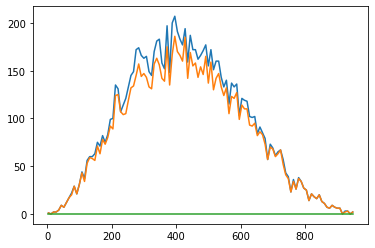

In [102]:
plt.plot(TDCR_D2D_Result_10k['frame'], TDCR_D2D_Result_10k['N_request'])
plt.plot(TDCR_D2D_Result_10k['frame'], TDCR_D2D_Result_10k['N_response'])
plt.plot(TDCR_D2D_Result_10k['frame'], TDCR_D2D_Result_10k['N_HL'])

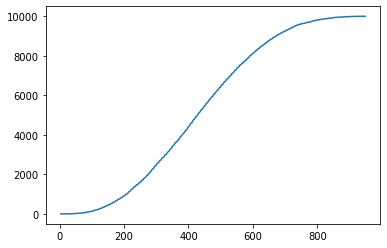

In [104]:
plt.plot(np.cumsum(TDCR_Device_Result_10k.groupby('RA_success').size()))

In [108]:
TDCR_D2D_Result_30k['N_HL'].max()

134

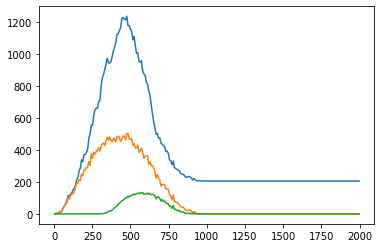

In [109]:
plt.plot(TDCR_D2D_Result_30k['frame'], TDCR_D2D_Result_30k['N_request'])
plt.plot(TDCR_D2D_Result_30k['frame'], TDCR_D2D_Result_30k['N_response'])
plt.plot(TDCR_D2D_Result_30k['frame'], TDCR_D2D_Result_30k['N_HL'])

In [110]:
TDCR_RA_Result_30k.groupby('TDCR').size()

TDCR
H      26
M      23
N    1951
dtype: int64